# Tariff recommendation
## Part 2. Solving the classification problem

**The goal of this study** is to select the optimal model for predicting the appropriate tariff (classification task). In the first part of the project we have already prepared the data, so now we will simply load it into the environment.

**The workflow of the second part of the project** includes consideration of several classifiers, selection of optimal hyperparameters and validation of the most "successful" model on a test set.

The selected metric to evaluate the model's performance is `accuracy`.

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv('/datasets/users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


### Data description
Each object in the dataset is information about the behavior of one user in a month. It's known that:

- `calls` - number of calls,
- `minutes` - total duration of calls in minutes,
- `messages` - number of sms-messages,
- `mb_used` - used Internet traffic in MB,
- `is_ultra` - what tariff was used during the month ("Ultra" - 1, "Smart" - 0).

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


The data is already preprocessed and free of omissions. 

Since there is a classification problem to be solved, the existing balance of classes should also be looked at:

In [4]:
data['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

There is a pronounced class imbalance in the data presented: approximately 70% Class 0 (*Smart tariff*) and 30% Class 1 (*Ultra tariff*).

## Splitting the data into samples

Since it is required to build a model to predict the appropriate tariff, the values of the *target variable* are recorded in the `is_ultra` column: 1 - *Ultra tariff*, 0 - *Smart tariff.*

In [5]:
features = data.drop('is_ultra', axis=1)
target = data['is_ultra']

Let's divide the dataset into three sets: train, validation and test in the ratio of 3:1:1.

In [6]:
# let's extract a test set from the data
features_full_train, features_test, target_full_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target)

# divide the remaining data into training and validation sets
features_train, features_valid, target_train, target_valid = train_test_split(
    features_full_train, target_full_train, test_size=0.25, random_state=12345, stratify=target_full_train)

In [7]:
features_train.shape[0], features_valid.shape[0], features_test.shape[0]

(1928, 643, 643)

## Examination of ML models

Consider several well-known classification models: *decision tree*, *random forest*, and *logistic regression*. The metric for model comparison is **accuracy** (proportion of correct answers).

### Decision Tree
The decision tree is characterized by the following hyperparameters:
- `max_depth` - maximum depth of the tree
- `criterion` - splitting criterion (variants:*gini*, *entropy*)
- `min_samples_split` - minimum number of objects in a node sufficient for splitting (default: 2)
- `min_samples_leaf` - minimum number of objects in leaves (default: 1)

We will vary the first 2 hyperparameters to find a better implementation of the algorithm.

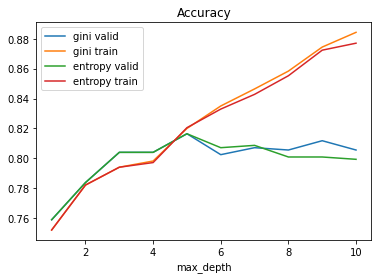

In [8]:
best_tree_model = None
best_criterion = None
best_max_depth = 0
best_result = 0

for sep_criterion in ['gini', 'entropy']:
    
    accuracy_valid_list, accuracy_train_list = [], []
    
    for depth in range(1, 11):
        model = DecisionTreeClassifier(max_depth=depth, criterion=sep_criterion, random_state=12345)
        model = model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        predictions_train = model.predict(features_train)
        
        accuracy_valid = accuracy_score(target_valid, predictions_valid)
        accuracy_train = accuracy_score(target_train, predictions_train)
        
        if accuracy_valid > best_result:
            best_tree_model = model
            best_criterion = sep_criterion
            best_max_depth = depth
            best_result = accuracy_valid
    
        accuracy_valid_list.append(accuracy_valid)
        accuracy_train_list.append(accuracy_train)
    
    plt.plot(range(1, 11), accuracy_valid_list, label=f'{sep_criterion} valid')
    plt.plot(range(1, 11), accuracy_train_list, label=f'{sep_criterion} train')

plt.legend()
plt.title('Accuracy')
plt.xlabel('max_depth')
plt.show()

In [9]:
print('Наибольшее значение accuracy =', round(best_result, 3))
print(f'Гиперпараметры дерева решений: criterion = {best_criterion}, max_depth = {best_max_depth}')

Наибольшее значение accuracy = 0.816
Гиперпараметры дерева решений: criterion = gini, max_depth = 5


In [10]:
# to store the results of optimal models
models_dict = {}
models_dict['DecisionTree'] = best_result

As can be seen from the graph, the optimal solution is to choose the maximum tree depth equal to 5. If the hyperparameter is increased, overtraining is observed, and if it is decreased, undertraining is observed. At the same time, the choice of the separation criterion will not affect the change of the metric value (the maximum is reached at the same point).

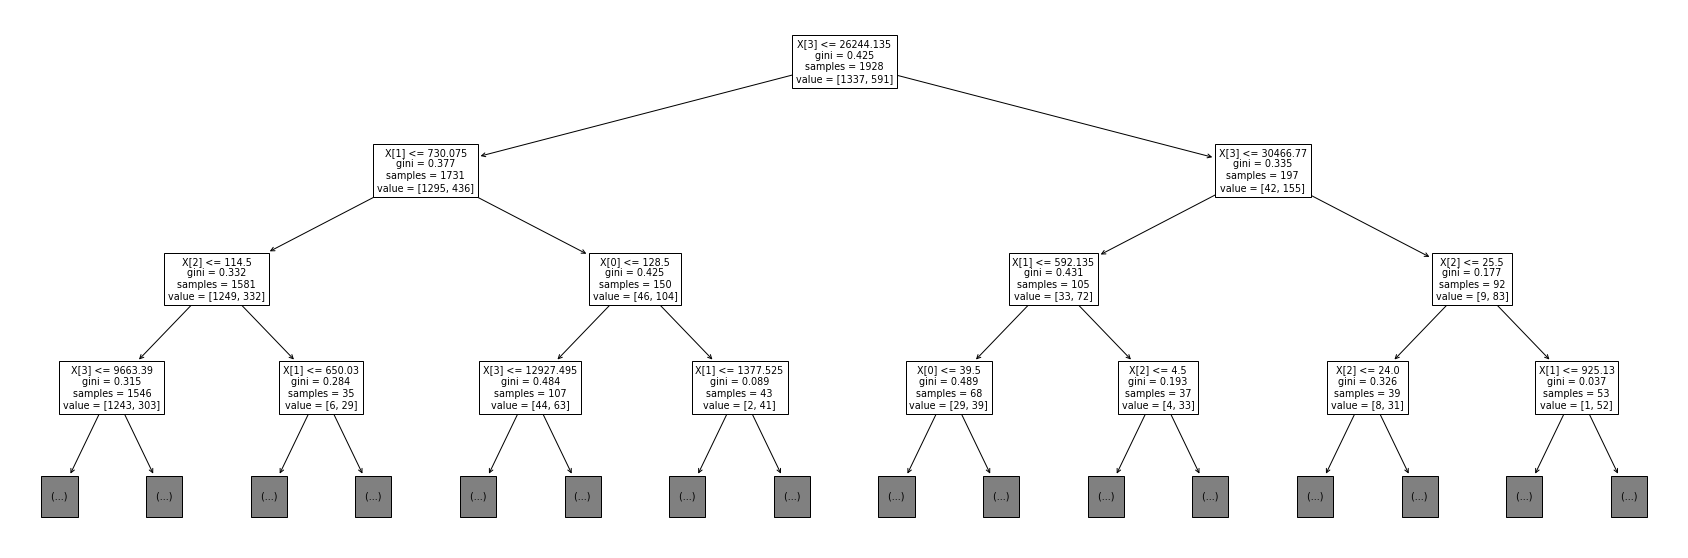

In [11]:
# decision making in the created tree
plt.figure(figsize=(30, 10))
plot_tree(best_tree_model, max_depth=3)
plt.show()

### Random forest
Since a *random forest* is an ensemble of several solving trees, `n_estimators` - the number of trees in the forest - is added to the set of hyperparameters.

We will vary the same hyperparameters as in the previous case + the new one added.

In [12]:
%%time

best_forest_model = None
best_criterion = None
best_max_depth = 0
best_est = 0
best_result = 0

for sep_criterion in ['gini', 'entropy']:
    for est in range(1, 51, 5):
        for depth in range(1, 11):
            model = RandomForestClassifier(n_estimators=est, max_depth=depth, criterion=sep_criterion, random_state=12345)
            model = model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            accuracy = accuracy_score(target_valid, predictions)
        
            if accuracy > best_result:
                best_forest_model = model
                best_criterion = sep_criterion
                best_max_depth = depth
                best_est = est
                best_result = accuracy

CPU times: user 13.6 s, sys: 169 ms, total: 13.8 s
Wall time: 13.8 s


In [13]:
print('Наибольшее значение accuracy =', round(best_result, 3))
print(f'Гиперпараметры случайного леса: criterion = {best_criterion}, max_depth = {best_max_depth}, n_estimators = {best_est}')

Наибольшее значение accuracy = 0.829
Гиперпараметры случайного леса: criterion = gini, max_depth = 8, n_estimators = 16


In [14]:
models_dict['RandomForest'] = best_result

In [15]:
%%time

model = RandomForestClassifier()

parameters = { 'n_estimators': range (1, 51, 5),
              'max_depth': range (1,11),
              'criterion': ['gini', 'entropy']}

grid = GridSearchCV(model, parameters, scoring='accuracy')
grid.fit(features_full_train, target_full_train)

CPU times: user 1min 11s, sys: 842 ms, total: 1min 12s
Wall time: 1min 12s


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 11),
                         'n_estimators': range(1, 51, 5)},
             scoring='accuracy')

In [16]:
# models_dict['RandomForest_new'] = grid.best_score_
print('New accuracy:', round(grid.best_score_, 3))
print('Оптимальные параметры:', grid.best_params_)

New accuracy: 0.809
Оптимальные параметры: {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 26}


### Logistic regression
There are no hyperparameters that can critically affect the result of *logistic regression*, so train the model with default parameters and look at the value of the metric.

In [17]:
model = LogisticRegression(random_state=12345)
new_model = model.fit(features_train, target_train)
predictions = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predictions)

In [18]:
print('Accuracy логистической регрессии =', round(accuracy, 3))

Accuracy логистической регрессии = 0.756


In [19]:
models_dict['LogisticRegression'] = accuracy

### Conclusion:

Thus, the model trained by the *Random Forest* algorithm with the following values of hyperparameters showed the best result:
- **separation criterion**: Ginny
- **maximum tree depth**: 8
- **number of trees in the ensemble**: 16 

Proportion of correct answers in the validation sample: **0.829**.

In [20]:
# Initiation of the final model
best_model = best_forest_model

## The model checking on a test set

In [21]:
predictions_test = best_model.predict(features_test)
print('Accuracy на тестовой выборке:', round(accuracy_score(target_test, predictions_test), 3))

Accuracy на тестовой выборке: 0.812


In 4 out of 5 cases, the selected model gives the correct answer. Let's try to increase the quality metric by re-training the model with the selected values of hyperparameters, but on a "common" sample: train+valid.

In [27]:
full_model = RandomForestClassifier(n_estimators=16, max_depth=8, criterion='gini', random_state=12345)
full_model = full_model.fit(features_full_train, target_full_train)
predictions_valid = full_model.predict(features_valid)
predictions_test = full_model.predict(features_test)

print('Accuracy на валидационной выборке:', round(accuracy_score(target_valid, predictions_valid), 3))
print('Accuracy на тестовой выборке:', round(accuracy_score(target_test, predictions_test), 3))

Accuracy на валидационной выборке: 0.868
Accuracy на тестовой выборке: 0.82


For comparison, we use a random forest model with parameters optimized with GridSearchCV:

In [23]:
predictions_test = grid.best_estimator_.predict(features_test)
print('Accuracy на тестовой выборке:', round(accuracy_score(target_test, predictions_test), 3))

Accuracy на тестовой выборке: 0.809


The result is a little worse.

## Checking the model for adequacy

In [24]:
target.value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

The data presented are characterized by an imbalance of classes: approximately 70% are class 0 (*Smart*) and 30% are class 1 (*Ultra*). The distribution is similar for the training sample.

Then the proportion of correct answers for the **constant model** (a model that in any case defines an object to one class, e.g. 0):

In [25]:
target_valid.value_counts(normalize=True).head(1)

0    0.693624
Name: is_ultra, dtype: float64

In [26]:
# другие модели
for key, value in models_dict.items():
    print('Accuracy для оптимальной модели', key, 'равно', round(value, 3))

Accuracy для оптимальной модели DecisionTree равно 0.816
Accuracy для оптимальной модели RandomForest равно 0.829
Accuracy для оптимальной модели LogisticRegression равно 0.756


The value for the constant model is lower than the obtained accuracy values for the considered models. Consequently, the constructed models predict correct answers better and can be considered **adequate**.

## Overall conclusion

**The main task of the project** was to solve a *binary classification* problem: to learn to predict the appropriate tariff (*Smart or Ultra*) for users based on data about the behavior of customers who have already made a choice. The data was provided in pre-processed form.

The study compared several classification algorithms - *Decision Tree*, *Random Forest* and *Logistic Regression*. For the models trained by the first two algorithms, optimal hyperparameters were selected to maximize the *delay of correct answers (accuracy)*, the metric chosen for evaluation. The models constructed were also further tested for adequacy by comparison with a simple constant model predicting a class 0 in 100% of cases.

**The best result** was the model trained with the *Random Forest* algorithm containing 16 independent solver trees, with maximum tree depth = 8 and a set Ginny separation criterion. 

Proportion of correct answers: **0.829** on the validation sample and **0.812** on the test sample (**0.82** if we train the model on the population of training and validation samples).